# 3D Volume to Volume GAN

In [1]:
%matplotlib inline

import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
from skimage.transform import resize
import time

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../scripts')

import pix3pix as p3p
import helper as hp
import data_loader3D as dl
import deconvolution as deconv

sys.path.insert(0, '../scripts/NanoImagingPack')
from microscopy import PSF3D

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

## look for the data

In [4]:
dataset_name = 'NESb'
path = glob('../data/3D/{0}/*'.format(dataset_name))
path = [item for item in path if not item.endswith('.txt')]

dl.print_volume_dimension(path)

dimensions of volumes:
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)


## create TFRecord file

In [5]:
vol_dim = (128, 128, 9)

data_loader = dl.DataLoader3D(dataset_name='NESb', vol_resize=vol_dim)
filename = '../data/TFRecords/{0}_train.tfrecords'.format(dataset_name)

# data_loader.writeTFRecord(filename)

## test the 3D psf for a random volume

In [6]:
path = '../data/3D/NESb/NESb_C2_TP1.tiff'
vol = io.imread(path)
vol = hp.swapAxes(vol, swap=True)
vol = resize(image=vol, output_shape=vol_dim)
print('image after resize in x/y dimension:', vol.shape)

# compute OTF
start_otf = time.time()
otf = PSF3D(im=vol.shape, ret_val = 'OTF')
end_otf = time.time()

# perform convolution on stack with computed otf (with numpy)
start_conv_np = time.time()
vol_otf = deconv.conv3d_fft(vol, otf)
end_conv_np = time.time()

# perform convolution on stack with computed otf (with tensorflow)
# start_conv_tf = time.time()
# vol_otf_tf = deconv.conv3d_fft_tf(vol, otf)
# end_conv_tf = time.time()

# select a random stacks
i = np.random.randint(low=0, high=vol.shape[2], size=1)[0]
print('stack number:\t\t\t', i+1,'/',vol.shape[2])
img = vol[:,:,i]
img_otf = vol_otf[:,:,i]
# img_otf_tf = vol_otf_tf[:,:,i]

print('Time for compute OTF:\t\t', end_otf - start_otf, 's')
print('Time for convolve with numpy:\t', end_conv_np - start_conv_np, 's')
# print('Time for convolve with tensorflow:\t', end_conv_tf - start_conv_tf, 's')

image after resize in x/y dimension: (128, 128, 9)
stack number:			 3 / 9
Time for compute OTF:		 0.03952598571777344 s
Time for convolve with numpy:	 0.024517297744750977 s


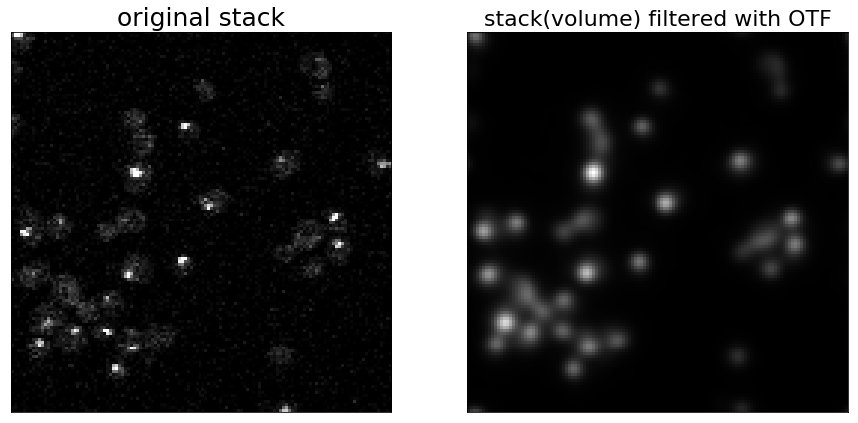

In [10]:
f = plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img, cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('original stack', fontsize=25)
plt.subplot(122); plt.imshow(img_otf, cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('stack(volume) filtered with OTF', fontsize=22)
# plt.subplot(133); plt.imshow(img_otf_tf, cmap='gray'); plt.xticks([]); plt.yticks([])
plt.show()

## initialize the volume to volume GAN

In [19]:
volume_resize = vol_dim #(256, 256, 9)
directory_name = dataset_name #'NESb'

gan = p3p.Pix3Pix(vol_resize=volume_resize, d_name=directory_name,
                  stack_manipulation=p3p.MANIPULATION.SPATIAL_MIN)
                  
                 #.SPATIAL_MIN
                 #.SPATIAL_DOWN                  
                 #.SPATIAL_UP
                 #.FREQUENCY_UP
                 #.FREQUENCY_DOWN

discriminator-resize: (?, 128, 128, 8, 1) (?, 128, 128, 8, 1)
discriminator-model in/output:	 (?, 128, 128, 9, 1) (?, 128, 128, 9, 1) 
				 (?, 16, 16, 1, 1)
generator-model input:		 (?, 128, 128, 9, 1)
<class 'numpy.int32'> -1 resize_stack_0: (?, 128, 128, 9, 1)
resize_stack_1: (?, 9, 1, 128, 128)
resize_stack_2: (1, 9, 1, 16384)
resize_stack_3: (1, 8, 1, 16384) 8
resize_stack_4: (1, 8, 1, 128, 128)
resize_stack_5: (1, 128, 128, 8, 1)
generator-resize: (?, 128, 128, 8, 1)
downsampling:			 (?, 64, 64, 4, 64)
downsampling:			 (?, 32, 32, 2, 128)
downsampling:			 (?, 16, 16, 1, 256)
downsampling:			 (?, 8, 8, 1, 512)
downsampling:			 (?, 4, 4, 1, 512)
upsampling:			 (?, 8, 8, 1, 512)
upsampling:			 (?, 16, 16, 1, 256)
upsampling:			 (?, 32, 32, 2, 128)
upsampling:			 (?, 64, 64, 4, 64)
generator-resize: (?, 128, 128, 8, 1)
generator-model output:		 (?, 128, 128, 9, 1) (?, 128, 128, 9, 1)
finish Pix3Pix __init__


## train volume to volume GAN

In [ ]:
epochs = 1

discriminator, generator, combined = gan.train(epochs=epochs, add_noise=True)

# release GPU memory

In [ ]:
del gan

In [ ]:
try:
    del discriminator, generator, combined
except:
    print('models not available')

In [ ]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

# plot random volume with 3 random stacks of GAN

In [ ]:
result_path = 'images/{0}/*'.format(dataset_name) 

model_vols = glob(result_path)
selected_folder = model_vols[-1]+'/*'

volumes = glob(selected_folder)
volumes = np.random.choice(volumes, size=1)[0]
vol_plot = io.imread(volumes)
cut = 120; ed = vol_plot.shape[0]
vol_plot = vol_plot[cut:ed-cut, cut:ed-cut , :]

print('plotted volume:', volumes, '\nvolume shape:', vol_plot.shape)
f = plt.figure(figsize=(25,25))
plt.imshow(vol_plot); plt.xticks([]); plt.yticks([]); plt.title('sampled from the model', fontsize=25);

In [ ]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant(3.0)
with tf.Session() as sess:
    print(sess.run(a))
        
# I believe that you need to set CUDA_VISIBLE_DEVICES=1. Or which ever GPU you want to use. 
#If you make only one GPU visible, you will refer to it as /gpu:0 regardless of what you set the environment variable to.
#More info on that environment variable: http://www.acceleware.com/blog/cudavisibledevices-masking-gpus

# https://stackoverflow.com/questions/40069883/how-to-set-specific-gpu-in-tensorflow

In [ ]:
a = np.arange(9).reshape((3, 3))
b = np.arange(9)- 4 
b = b.reshape((3, 3))
print(a,'\n\n', b)

In [ ]:
np.linalg.norm(a-b, ord='fro')

In [ ]:
from keras import losses

losses.kullback_leibler_divergence
losses.mean_squared_error
losses.mean_squared_logarithmic_error
losses.sparse_categorical_crossentropy

tf.image.ResizeMethod.BILINEAR